In [2]:
import numpy as np
import matplotlib.pyplot as plt
from vebtf_sparse import VEBTF_sparse
from vebtf import VEBTF
from utils import sym_tridiagonal_inverse, denoise_wavelet_ti,trend_filter
from scipy.linalg import solveh_banded
import seaborn as sns
sns.set(style="darkgrid")

In [3]:

def generate_signals(n=1024, signal=7):
    x = np.linspace(1/n, 1, n)
    t = np.array([0.1, 0.13, 0.15, 0.23, 0.25, 0.4, 0.44, 0.65, 0.76, 0.78, 0.81])
    h1 = np.array([4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2])
    blocks = np.zeros(n)
    for i in range(len(h1)):
        blocks += h1[i] * (1 + np.sign(x - t[i])) / 2

    h2 = np.array([4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 5.1, 4.2])
    w = np.array([0.005, 0.005, 0.006, 0.01, 0.01, 0.03, 0.01, 0.01, 0.005, 0.008, 0.005])
    bumps = np.zeros(n)
    for i in range(len(h2)):
        bumps += h2[i] * np.maximum(0, (1 - np.abs((x - t[i]) / w[i]))) ** 4

    heavi = 4 * np.sin(4 * np.pi * x) - np.sign(x - 0.3) - np.sign(0.72 - x)
    eps = 0.05
    doppler = np.sqrt(x * (1 - x)) * np.sin((2 * np.pi * (1 - eps)) / (x + eps))

    blocks = blocks / np.sqrt(np.var(blocks)) * signal
    bumps = bumps / np.sqrt(np.var(bumps)) * signal
    heavi = heavi / np.sqrt(np.var(heavi)) * signal
    doppler = doppler / np.sqrt(np.var(doppler)) * signal

    return blocks, bumps, heavi, doppler

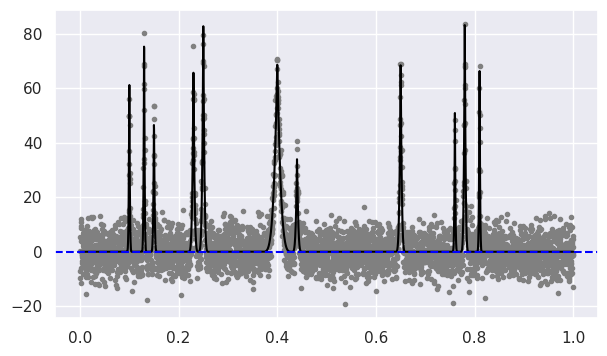

In [4]:
np.random.seed(5)
np.random.seed(6)
np.random.seed(8)
n=2**12
sigma=5
x = np.linspace(1/n, 1, n)
mu,mu1,mu2,mu3 = generate_signals(n=n, signal=10)
y = mu1 + np.random.normal(0, sigma, n)
plt.figure(figsize=(7,4))
plt.plot(x, y, '.',color='grey')
plt.plot(x, mu1, 'black')
plt.axhline(y=0, color='blue', linestyle='--')
plt.show()

In [9]:
model = VEBTF(printevery=1,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000)
model.fit(y,mu_init="wavelet")

Iteration 0: ELBO = -19316.85336874194
Iteration 1: ELBO = -19221.926407270257
Iteration 2: ELBO = -19200.391837363204
Iteration 3: ELBO = -19196.669035861392
Iteration 4: ELBO = -19195.59963181481
Iteration 5: ELBO = -19195.013814112437
Iteration 6: ELBO = -19194.679075463584
Iteration 7: ELBO = -19194.471188013555
Iteration 8: ELBO = -19194.33269458705
Iteration 9: ELBO = -19194.244785459094
Iteration 10: ELBO = -19194.190947145413
Iteration 11: ELBO = -19194.155869254013


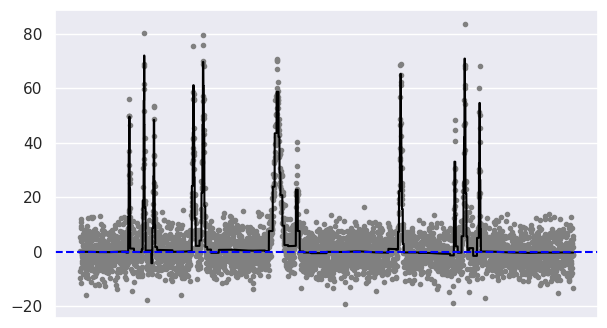

In [10]:

plt.figure(figsize=(7,4))
plt.plot([i for i in range(len(y))], y, '.',color='grey')
plt.plot([i for i in range(len(y))],model.mu, 'black')
plt.axhline(y=0, color='blue', linestyle='--')
plt.xticks([])
# plt.savefig("ebtf_nonsparse.pdf",bbox_inches='tight')
plt.show()

In [11]:
model = VEBTF_sparse(printevery=1,prior="ash_update",tol=1e-8,point_mass_sd=np.sqrt(1/n)/2,point_mass_sd0=np.sqrt(1/n)/4,maxiter=1000,lambda0=0,fix_sigma2=False)
model.fit(y,mu_init="wavelet")

Iteration 0: ELBO = -21083.90376918661
Iteration 1: ELBO = -20822.07309960148
Iteration 2: ELBO = -20666.219929264906
Iteration 3: ELBO = -20552.563237156843
Iteration 4: ELBO = -20460.034705186255
Iteration 5: ELBO = -20386.425811926252
Iteration 6: ELBO = -20329.400565091448
Iteration 7: ELBO = -20286.152314812385
Iteration 8: ELBO = -20253.863724345792
Iteration 9: ELBO = -20230.024076751994
Iteration 10: ELBO = -20212.5570147303
Iteration 11: ELBO = -20199.825554133735
Iteration 12: ELBO = -20190.57836208599
Iteration 13: ELBO = -20183.877814534073
Iteration 14: ELBO = -20179.0304071414
Iteration 15: ELBO = -20175.527497656225
Iteration 16: ELBO = -20172.998105697116
Iteration 17: ELBO = -20171.172650480927
Iteration 18: ELBO = -20169.8557178521
Iteration 19: ELBO = -20168.905894687956
Iteration 20: ELBO = -20168.220977836478
Iteration 21: ELBO = -20167.727152429412
Iteration 22: ELBO = -20167.37113797175
Iteration 23: ELBO = -20167.114489213403
Iteration 24: ELBO = -20166.92948476

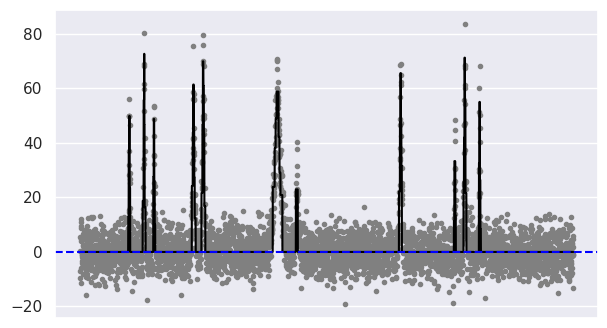

In [12]:
sns.set(style="darkgrid")
plt.figure(figsize=(7,4))
plt.plot([i for i in range(len(y))], y, '.',color='grey')
plt.plot([i for i in range(len(y))],model.mu, 'black')
plt.axhline(y=0, color='blue', linestyle='--')
plt.xticks([])
# plt.savefig("ebtf_sparse.pdf",bbox_inches='tight')
plt.show()